In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sys
import torch as pt
import math

sys.path.insert(0, '..')

from function_space import Linear
from problems import LQGC
from solver import Solver,mySolver,mySolver_problemdependent
from utilities import do_importance_sampling, plot_loss_logs, plot_solution, save_exp_logs, load_exp_logs

%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

seed = 42

lqgc = LQGC(d=2, off_diag=0.1, T=50, seed=seed, delta_t=1)#no need anymore
IS_K = 20000#no need any more

d = 20
print_every = 1
lr = 0.001 # 0.1 with Adam # 10.0 with SGD 
K = 2000
L = 50
delta_t = 0.01
T = 0.5
OBsigma2 = 1
K_BPF_large, K_BPF_small = 100000, 200
replicate_num = 1000

resample_kappa = 1

/home/jytorch/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# get observation value

In [2]:
def b(x):
    bi, bj = pt.meshgrid(pt.arange(d), pt.arange(d))
    alpha = 0.5
    bA = alpha ** (pt.abs(bi - bj) + 1)
    bA = bA.to(device)

    # bbeta = 0.1
    # bA = pt.eye(d).to(device) 
    # bA[-1, -1] = bbeta

    #return (pt.mm(bA, x.t()).t() - x) / delta_t
    #return -pt.mm(bA, x.t()).t()
    return -x 

#get y_observed
#consider the OU process: dX = -X + dW y_t \sim N(\cdot,X_t)
#observemethod = 'naive'
observemethod = 'observe'
y_observed = []
X_forOB = pt.ones(d).to(device).repeat(1, 1).to(device)#initial fixed
N_forOB = int(T / delta_t)
for n in range(N_forOB+1):
    print(X_forOB, end = ' ,')
    if(observemethod == 'observe'):
      y_observed.append(X_forOB + math.sqrt(OBsigma2) * pt.randn_like(X_forOB))#observe y
    if(observemethod == 'naive'):
      y_observed.append(pt.zeros_like(X_forOB).to(device))
    X_forOB = X_forOB + delta_t * b(X_forOB) + math.sqrt(delta_t) * pt.randn_like(X_forOB).to(device)#move forward
print(1)
print('observed value:', y_observed)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0') ,tensor([[1.0039, 0.9792, 0.9183, 1.0657, 1.0271, 0.8895, 0.9908, 1.0228, 1.0183,
         0.9007, 0.9737, 0.9094, 0.9783, 0.8288, 0.9746, 0.9835, 0.9368, 0.9953,
         0.9869, 0.9157]], device='cuda:0') ,tensor([[0.9241, 0.7825, 0.8208, 0.8887, 0.9736, 0.9757, 1.0471, 1.0170, 1.0653,
         1.1112, 0.9393, 0.7620, 0.9746, 0.7962, 1.0967, 1.0258, 0.8665, 0.9954,
         0.8874, 0.8128]], device='cuda:0') ,tensor([[1.0613, 0.7423, 0.8899, 1.0388, 0.7964, 0.9669, 0.9224, 0.8849, 0.8828,
         1.0702, 0.9410, 0.8995, 0.8591, 0.8402, 1.0654, 1.0540, 0.9884, 0.9743,
         0.8390, 0.7754]], device='cuda:0') ,tensor([[1.1289, 0.8746, 0.8629, 0.8965, 0.8167, 1.0802, 1.0392, 0.8587, 0.7203,
         1.0855, 0.8584, 0.9009, 0.8303, 0.8683, 1.0866, 0.8606, 0.8245, 1.0222,
         1.0366, 0.6495]], device='cuda:0') ,tensor([[1.2163, 1.0304, 0.8434, 0.9967, 0.8705, 1.133

/home/jytorch/.local/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# get analytical solution for Gauss linear model (decoupling case)

In [3]:
'''
get analytical solution for Gauss linear model
recursively solve mu_k, sigma2_k, C_k for phi_k(x) = C_k N(mu_k,sigma2_k)
given y0,...yn, delta_t, OBsigma2, OUa (OUa=-1 for dX = -Xdt + dW)
'''


specialcase = 0


if(specialcase == 1):
    OUa = -1
    mu_k, sigma2_k, C_k, yk = [], [], [], []
    for i in range(int(T / delta_t) + 1):
        mu_k.append(y_observed[i].to('cpu').numpy())
        sigma2_k.append(1.0)
        C_k.append(1.0)
        yk.append(y_observed[i].to('cpu').numpy())

    #k = n


    mu_k[int(T / delta_t)] = yk[int(T / delta_t)]
    sigma2_k[int(T / delta_t)] = OBsigma2
    #C_k[int(T / delta_t)] = 1#if gk = (2pisigma)^{-d/2}exp(...)
    C_k[int(T / delta_t)] = np.power(2 * np.pi * OBsigma2, +d/2)#if gk = exp(...)

    #recursive get C_k, mu_k,sigma2_k
    kk = int(T / delta_t) - 1
    while(kk >= 0):
        mu_k[kk] = ((sigma2_k[kk+1] + delta_t) * yk[kk] + OBsigma2 * (1 + OUa * delta_t) * mu_k[kk+1])\
            / (sigma2_k[kk+1] + delta_t + OBsigma2 * (1 + OUa * delta_t)**2)
        
        sigma2_k[kk] = (OBsigma2 * (sigma2_k[kk+1] + delta_t)) / (sigma2_k[kk+1] + delta_t + OBsigma2 * (1 + OUa * delta_t)**2)

        #gk = exp(...)
        C_k[kk] = C_k[kk+1]  * np.power((sigma2_k[kk+1] + delta_t) / sigma2_k[kk], -d/2)\
                * np.exp(- ((sigma2_k[kk+1] + delta_t) * np.linalg.norm(yk[kk])**2 + OBsigma2 * np.linalg.norm(mu_k[kk+1])**2)\
                            / (2 * OBsigma2 *(sigma2_k[kk+1] + delta_t))\
                            + (np.linalg.norm((sigma2_k[kk+1] + delta_t) * yk[kk] + OBsigma2 * (1 + OUa * delta_t) * mu_k[kk+1])**2)\
                                / (2 * OBsigma2 * (sigma2_k[kk+1] + delta_t) * (sigma2_k[kk+1] + delta_t + OBsigma2 * (1 + OUa * delta_t)**2))) 

        # #gk = cexp(...)
        # C_k[kk] = C_k[kk+1] * math.pow(2 * math.pi * OBsigma2, -d/2) * math.pow(2 * math.pi * (sigma2_k[kk+1] + delta_t), -d/2)\
        #       * math.pow(2 * math.pi * sigma2_k[kk], +d/2)\
        #           * math.exp(- ((sigma2_k[kk+1] + delta_t) * np.linalg.norm(yk[kk])**2 + OBsigma2 * np.linalg.norm(mu_k[kk+1])**2)\
        #                       / (2 * OBsigma2 *(sigma2_k[kk+1] + delta_t))\
        #                       + (np.linalg.norm((sigma2_k[kk+1] + delta_t) * yk[kk] + OBsigma2 * (1 + OUa * delta_t) * mu_k[kk+1])**2)\
        #                           / (2 * OBsigma2 * (sigma2_k[kk+1] + delta_t) * (sigma2_k[kk+1] + delta_t + OBsigma2 * (1 + OUa * delta_t)))) 
        # #print(C_k[kk], sigma2_k[kk],mu_k[kk])
        kk = kk - 1

    print('analytical solution for twisting function done!')


    #calculate Z = phi*0(X0)
    X0_fortrue = np.ones(d)
    Z_true = C_k[0] * math.pow(2 * math.pi * sigma2_k[0], -d/2) * math.exp(-np.linalg.norm(X0_fortrue - mu_k[0])**2 / (2 * sigma2_k[0]))
    print('analytical solution: Z_true = ', Z_true, 'log Ztrue:', np.log(Z_true))    




# analytical solution by pykalman (general linear gaussian case)

In [4]:
from pykalman import KalmanFilter

N = int(T / delta_t)

'''
run KF
'''
#define drift
bi, bj = pt.meshgrid(pt.arange(d), pt.arange(d))
alpha = 0.05
bA = alpha ** (pt.abs(bi - bj) + 1)
#bA_np = (bA.numpy() - np.eye(d)) / delta_t
bA_np = -bA.numpy()

# bbeta = 0.1
# bA_np = np.eye(d)
# bA_np[-1, -1] = bbeta

bA_np = -np.eye(d) 


observations = np.array([y_observed[i].squeeze().to('cpu').numpy() for i in range(N+1)])

transition_matrix = np.eye(d) + delta_t * (bA_np)
observation_matrix = np.eye(d)
transition_covariance = np.eye(d) * delta_t
observation_covariance = np.eye(d) * OBsigma2

initial_state_mean = np.ones(d)  
initial_state_covariance = np.eye(d) * 0.00000000001#fixed initial

kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_covariance=transition_covariance,
    observation_covariance=observation_covariance,
    initial_state_mean=initial_state_mean,
    initial_state_covariance=initial_state_covariance
)

filtered_state_means, filtered_state_covariances = kf.filter(observations)
print('KF done')


log_Z_KF = 0.0
for n in range(N+1):
    if n == 0:
        
        y_k = observations[n]
        Hx_k =  initial_state_mean
        S_k =  initial_state_covariance + observation_covariance
        log_p_yk_given_y1k1 = -0.5 * (np.log(np.linalg.det(S_k)) + (y_k - Hx_k).T @ np.linalg.inv(S_k) @ (y_k - Hx_k) + d * np.log(2 * np.pi))
    else:
        
        y_k = observations[n]
        Hx_k =  filtered_state_means[n-1]
        S_k =  filtered_state_covariances[n-1]  + observation_covariance
        log_p_yk_given_y1k1 = -0.5 * (np.log(np.linalg.det(S_k)) + (y_k - Hx_k).T @ np.linalg.inv(S_k) @ (y_k - Hx_k) + d * np.log(2 * np.pi))
    
    log_Z_KF += log_p_yk_given_y1k1 - (-(d/2) * np.log(2 * np.pi * OBsigma2))

    #print(f"Step {n}: log p(y_k|y_0:{n-1}) = {log_p_yk_given_y1k1}, log_Z = {log_Z}")

print('KF done, log_Z=', log_Z_KF)

KF done
KF done, log_Z= -537.8088454480593


# FA-APF

In [5]:
def gk(x):
    return np.exp(-np.linalg.norm(x, axis=1)**2 / (2 * OBsigma2))

def vectorized_gaussian_multiplication(mu1, sigma1, mu2, sigma2):
    '''
    Vectorized computation for mean, cov, and integral of N(\cdot;mu1,sigma1) * N(\cdot;mu2,sigma2)
    '''
    d = mu1.shape[1]

    inv_sigma1 = np.linalg.inv(sigma1)
    inv_sigma2 = np.linalg.inv(sigma2)
    cov = np.linalg.inv(inv_sigma1 + inv_sigma2)
    cov_inv = inv_sigma1 + inv_sigma2
    mean = np.einsum('...ij,...j->...i', cov, np.einsum('...ij,...j->...i', inv_sigma1, mu1) + np.einsum('...ij,...j->...i', inv_sigma2, mu2))

    integral = np.power(2 * np.pi, d/2) * np.sqrt(np.abs(np.linalg.det(cov)))\
          * np.exp(0.5 * np.einsum('...i,...i->...', mean, np.einsum('...ij,...j->...i', cov_inv, mean))\
                    - 0.5 * np.einsum('...i,...i->...', mu1, np.einsum('...ij,...j->...i', inv_sigma1, mu1))\
                          - 0.5 * np.einsum('...i,...i->...', mu2, np.einsum('...ij,...j->...i', inv_sigma2, mu2)))

    return mean, cov, integral

# Vectorized FA-APF

obs = np.array([y_observed[i].squeeze().to('cpu').numpy() for i in range(N + 1)])
transition = np.eye(d) + delta_t * (bA_np)

K_FAAPF = 200
print('use', K_FAAPF, 'particles')

FAAPF_Z_forcompare, FAAPF_logZ_forcompare = [], []
y_observed_KBPFL = np.array([y_observed[n].repeat(K_FAAPF, 1).to('cpu').numpy() for n in range(N + 1)])

average_ESSnum_FAAPF = 0
ESS_ave = 0

for ii in range(replicate_num):

    ithESS_num = 0

    XX_FAAPF_np = np.ones((N + 1, K_FAAPF, d))  # initial particles
    
    g_prod = 1
    for n in range(N + 1):
        g_k = gk(XX_FAAPF_np[n] - y_observed_KBPFL[n])
        
        if n == N:
            gphi_k = np.ones(K_FAAPF)
        else:
            transition_x = np.dot(XX_FAAPF_np[n], transition.T)
            phimu_k, phicov_k, tildephi_k = vectorized_gaussian_multiplication(
                transition_x,
                np.tile(delta_t * np.eye(d), (K_FAAPF, 1, 1)),
                np.tile(obs[n + 1], (K_FAAPF, 1)),
                np.tile(OBsigma2 * np.eye(d), (K_FAAPF, 1, 1))
            )
            gphi_k = tildephi_k * np.power(2 * np.pi * delta_t, -d / 2)
            if n == 0:
                gphi_k *= g_k

        g_prod *= gphi_k.mean()

        #resample

        weights = gphi_k / gphi_k.sum()
        indices = np.random.choice(K_FAAPF, K_FAAPF, p=weights, replace=True)
        ESS = 1.0 / np.sum(weights**2)
        ESS_ave += ESS

        if(ESS <= resample_kappa * K_FAAPF):
            XX_FAAPF_np_rs = XX_FAAPF_np[n][indices]
            ithESS_num += 1
        else:
            XX_FAAPF_np_rs = XX_FAAPF_np[n]
        
        if n <= N - 1:
            transition_x = np.dot(XX_FAAPF_np_rs, transition.T)
            phimu_k, phicov_k, _ = vectorized_gaussian_multiplication(
                transition_x,
                np.tile(delta_t * np.eye(d), (K_FAAPF, 1, 1)),
                np.tile(obs[n + 1], (K_FAAPF, 1)),
                np.tile(OBsigma2 * np.eye(d), (K_FAAPF, 1, 1))
            )
            XX_FAAPF_np[n + 1] = np.array([np.random.multivariate_normal(mean=phimu_k[i], cov=phicov_k[i]) for i in range(K_FAAPF)])
    
    print(ii, 'logZ = ', np.log(g_prod), 'ESS number:', ithESS_num)
    FAAPF_Z_forcompare.append(g_prod)
    FAAPF_logZ_forcompare.append(np.log(g_prod))
    average_ESSnum_FAAPF += ithESS_num

average_ESSnum_FAAPF /= replicate_num
if(resample_kappa < 1):
    print('average ESS number:', average_ESSnum_FAAPF)


ESS_ave /= (replicate_num * (N+1))
print('average_ESS=', ESS_ave, 'average_ESS percentage = ', ESS_ave / K_FAAPF)

use 200 particles
0 logZ =  -545.4401462354139 ESS number: 51
1 logZ =  -541.593295991101 ESS number: 51
2 logZ =  -544.0426429313171 ESS number: 51
3 logZ =  -552.7219313063641 ESS number: 51
4 logZ =  -534.8086626514099 ESS number: 51
5 logZ =  -541.2319340111125 ESS number: 51
6 logZ =  -552.3839450466021 ESS number: 51
7 logZ =  -543.2676845962145 ESS number: 51
8 logZ =  -542.3153853431646 ESS number: 51
9 logZ =  -546.1933466927329 ESS number: 51
10 logZ =  -556.622432062775 ESS number: 51
11 logZ =  -553.4025542732074 ESS number: 51
12 logZ =  -551.3689610467661 ESS number: 51
13 logZ =  -548.2368944626359 ESS number: 51
14 logZ =  -541.0705438407142 ESS number: 51
15 logZ =  -555.7379633137241 ESS number: 51
16 logZ =  -543.7641083835402 ESS number: 51
17 logZ =  -540.5509992376675 ESS number: 51
18 logZ =  -540.2791680131187 ESS number: 51
19 logZ =  -547.1543883000361 ESS number: 51
20 logZ =  -549.2331570203612 ESS number: 51
21 logZ =  -540.3967801408846 ESS number: 51
22 l

# learn twisting function and run TPF

In [6]:
seed = 42
L = 2000
K = 200
lr = 0.001
print_every = 10
replicate_num = 1000

Z_true = np.exp(log_Z_KF)

models = [mySolver_problemdependent(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=1000, lr=0.001, seed=123,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'direct',
                   train_goal = 'REdirect',
                   d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                   Z_true = Z_true, resample_kappa = resample_kappa),

          mySolver_problemdependent(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=1000, lr=0.001, seed=123,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'direct',
                   train_goal = 'CEdirect',
                   d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                   Z_true = Z_true, resample_kappa = resample_kappa),

          mySolver_problemdependent(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=1000, lr=0.001, seed=123,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'direct',
                   train_goal = 'RECEdirect',
                   d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                   Z_true = Z_true, resample_kappa = resample_kappa),
    
            mySolver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted',
                   train_goal = 'RE',
                   d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                   Z_true = Z_true),
            mySolver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted',
                   train_goal = 'CE',
                     d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                     Z_true = Z_true),  
            mySolver(name='relative entropy', problem=lqgc, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                  K=K, IS_variance_K=IS_K,  detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, random_X_0=False,delta_t = delta_t,T = T,
                 sampling_method = 'untwisted', 
                 train_goal = 'CERE', 
                 d = d, OBsigma2 = OBsigma2, y_observed = y_observed,K_BPF_large = K_BPF_large,K_BPF_small=K_BPF_small,replicate_num = replicate_num,
                 Z_true = Z_true),   

                 ]

580 parameters in total.
580 parameters in total.
580 parameters in total.


In [7]:
#run BPF
K_BPF_small = 200
logZ_BPF = []
average_ESSnum_BPF = 0
ESS_ave = 0
for ii in range(replicate_num):
  ithESSnum = 0

  X0 = pt.ones(d).to(device)       
  X_BPF = X0.repeat(K_BPF_small, 1).to(device)

  y_observed_KBPFL = []#define y_OB for K_BPF_small particles
  for n in range(int(T/delta_t) + 1):
      y_observed_KBPFL.append(y_observed[n].repeat(K_BPF_small,1).to(device))

  # print(X_BPF.size(),y_observed_KBPFL[0].size())
  # print(asdfasdf)
  g_prod = 1
  #g_prod *= pt.exp(-models[0].f(X_BPF - y_observed_KBPFL[n], n * delta_t)).mean().item() 
  #g_prod = pt.ones(self.K_BPF_large).to(self.device)
  for n in range(models[0].N+1):
    g_k = pt.exp(-models[0].f(X_BPF - y_observed_KBPFL[n],n * models[0].delta_t))
    g_prod *= g_k.mean().item()
    
    #resample
    weights = g_k / pt.sum(g_k)
    indices = pt.multinomial(weights, K_BPF_small, replacement=True)
    ESS = 1.0 / np.sum((weights.to('cpu').numpy())**2)
    ESS_ave += ESS

    if(ESS <= resample_kappa * models[0].K_BPF_small):
      X_BPF = X_BPF[indices]
      ithESSnum += 1
    
    
    #update particle position
    X_BPF = X_BPF + models[0].delta_t * models[0].b(X_BPF) + models[0].sq_delta_t * pt.randn_like(X_BPF).to(device)
    
  logZ_BPF.append(np.log(g_prod))
  print('BPF done with', K_BPF_small, 'particles', 'Z:',g_prod, 'log Z:', np.log(g_prod), 'ESS number:',ithESSnum)
  average_ESSnum_BPF += ithESSnum

average_ESSnum_BPF /= replicate_num
if(resample_kappa < 1):
  print('average ESS number:', average_ESSnum_BPF)

ESS_ave /= (replicate_num * (N+1))
print('ESS_ave = ', ESS_ave, 'ESS_ave percentage=', ESS_ave / K_BPF_small)



BPF done with 200 particles Z: 3.0178740591153573e-239 log Z: -549.2132845960174 ESS number: 51
BPF done with 200 particles Z: 4.3480317268651194e-235 log Z: -539.6377735874813 ESS number: 51
BPF done with 200 particles Z: 5.967210133430112e-239 log Z: -548.5315577217311 ESS number: 51
BPF done with 200 particles Z: 1.8420014579431296e-242 log Z: -556.6147397752262 ESS number: 51
BPF done with 200 particles Z: 1.314135819514333e-242 log Z: -556.9524132264331 ESS number: 51
BPF done with 200 particles Z: 2.524260600504898e-236 log Z: -542.4841337582342 ESS number: 51
BPF done with 200 particles Z: 1.0518928142791069e-236 log Z: -543.3594907250375 ESS number: 51
BPF done with 200 particles Z: 1.0218246624347191e-239 log Z: -550.2962473116894 ESS number: 51
BPF done with 200 particles Z: 4.373363012030122e-238 log Z: -546.5397198514706 ESS number: 51
BPF done with 200 particles Z: 8.752867064337888e-237 log Z: -543.5432857283938 ESS number: 51
BPF done with 200 particles Z: 3.984089677876

In [8]:

#train
for i in range(6):
    if(i ==0  or i == 1 or i==2):
        models[i].update_Phis()
        models[i].train()

580 parameters in total.
lr= 0.001
BPF done with 100000 particles Z: 6.013150425831946e-235 log Z: -539.3135480450873
constants calculated with 100000 samples, without resampling
phi_0^*: 0.0 entropy_inCE: 0.0
logphi_0^*: -inf
N 50 T 0.5 delta_t 0.009999999776482582
iteration 0 

/home/jytorch/path-space-PDE-solver-master/Linear_Gaussian_model/../solver.py:576: RuntimeWarning: divide by zero encountered in log
  print('logphi_0^*:',np.log(phi0))


phi_40: tensor([[ -2.4684,   1.8513,  -5.7551,  -1.0532,  11.5404,  -5.5692,   0.5061,
           7.1924,   3.3985,  -2.3884,  14.4363,  -6.7691,   8.2113,   2.4790,
         -14.6728,  -3.3945,  -1.4034,  -0.8909,  -9.4991, -11.0537]],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([[0.7997]], device='cuda:0', grad_fn=<SoftplusBackward0>)  
REloss: 719.9284592394407 CEloss: 5.277475669396224e-23 RECEloss: 719.9284592394407 RelVar: 0.0 training time: 0.2711329460144043 running time: 0.6316077709197998
iteration 10 phi_40: tensor([[ -1.7256,   1.0347,  -3.7834,  -0.6663,   9.1392,  -2.7726,   1.2074,
           6.3229,   1.1054,  -0.6745,  11.0724,  -4.6693,   6.3154,   2.9795,
         -11.1059,  -1.4094,  -0.3722,  -1.6209,  -8.4208,  -9.0717]],
       device='cuda:0', grad_fn=<AddBackward0>) tensor([[3.0428]], device='cuda:0', grad_fn=<SoftplusBackward0>)  
REloss: 190.6434250597532 CEloss: 4.2785404332325574e-17 RECEloss: 190.6434250597532 RelVar: 0.0 training time: 0.232357

# training history

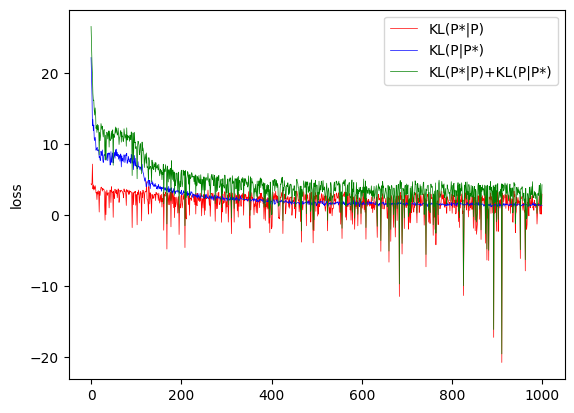

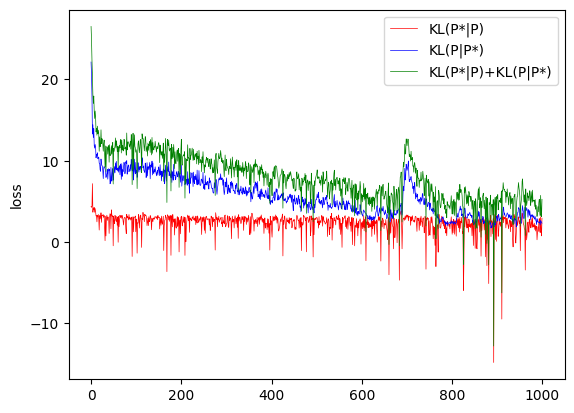

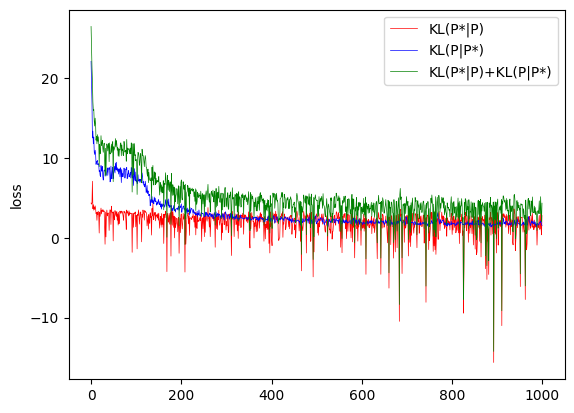

/tmp/ipykernel_1050951/16795951.py:15: RuntimeWarning: invalid value encountered in log
  CE, = plt.plot(np.log(5+np.array(models[i].loss_log_CE)), color = 'red', linewidth = 0.5)
/tmp/ipykernel_1050951/16795951.py:17: RuntimeWarning: invalid value encountered in log
  RECE, = plt.plot(np.log(5+np.array(models[i].loss_log_CERE)),color = 'green', linewidth = 0.5)


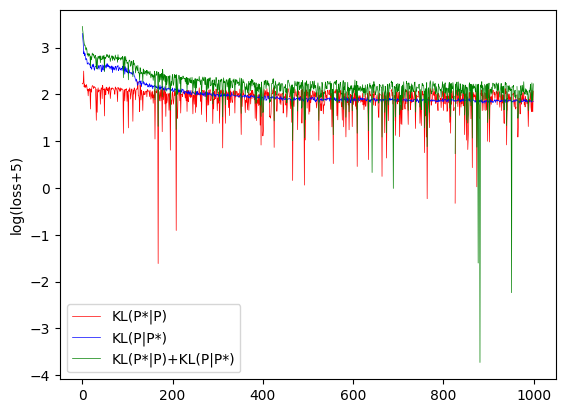

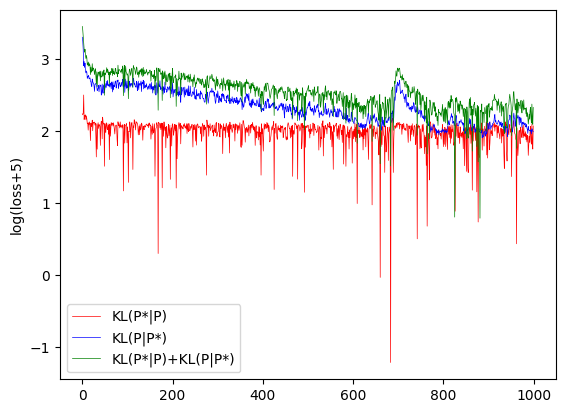

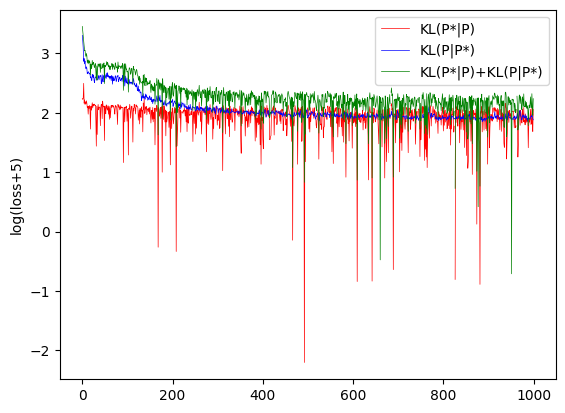

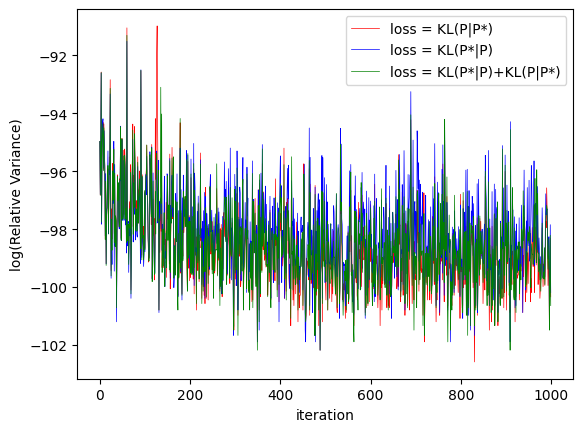

In [ ]:
#fig = plot_loss_logs('LQGC Adam', models) # lr = 0.1
for i in range(3):
    CE, = plt.plot(np.array(models[i].loss_log_CE), color = 'red', linewidth = 0.5)
    RE, = plt.plot(np.array(models[i].loss_log_REdirect) ,color = 'blue', linewidth = 0.5)
    RECE, = plt.plot(np.array(models[i].loss_log_CERE),color = 'green', linewidth = 0.5)

    plt.ylabel('loss')

    plt.legend(handles=[CE,RE,RECE],labels=['KL(P*|P)','KL(P|P*)','KL(P*|P)+KL(P|P*)'],loc='best')
    
    plt.show()


for i in range(3):
    CE, = plt.plot(np.log(5+np.array(models[i].loss_log_CE)), color = 'red', linewidth = 0.5)
    RE, = plt.plot(np.log(5+np.array(models[i].loss_log_REdirect)) ,color = 'blue', linewidth = 0.5)
    RECE, = plt.plot(np.log(5+np.array(models[i].loss_log_CERE)),color = 'green', linewidth = 0.5)

    plt.ylabel('log(loss+5)')

    plt.legend(handles=[CE,RE,RECE],labels=['KL(P*|P)','KL(P|P*)','KL(P*|P)+KL(P|P*)'],loc='best')
    
    plt.show()

var0, = plt.plot(np.log(np.array(models[0].relvar_log)),color = 'red', linewidth = 0.5)
var1, = plt.plot(np.log(np.array(models[1].relvar_log)),color = 'blue', linewidth = 0.5)
var2, = plt.plot(np.log(np.array(models[2].relvar_log)),color = 'green', linewidth = 0.5)



plt.ylabel('log(Relative Variance)')
plt.xlabel('iteration')



plt.legend(handles=[var0,var1,var2],labels=['loss = KL(P|P*)','loss = KL(P*|P)','loss = KL(P*|P)+KL(P|P*)'],loc='best')
plt.show()



# print(np.exp(models[0].Z_n_(models[0].X_0.repeat(1,1).to(models[0].device),0).item()))

# IAPF

In [9]:
'''
run IAPF in " The Iterated Auxiliary Particle Filter " or " Controlled Sequential Monte Carlo "
'''
from scipy.optimize import lsq_linear
import time

# np.seterr(all='ignore')
#print(mu_k[40], sigma2_k[40])

def gk(x):
    return np.exp(-np.linalg.norm(x, axis=1)**2 / (2 * OBsigma2))

def log_gk(x):
    return -np.linalg.norm(x, axis=1)**2 / (2 * OBsigma2)

def b_np(x):
    n, d = x.shape  

    bbi, bbj = np.meshgrid(np.arange(d), np.arange(d))
    alpha = 0.05
    bbA = alpha ** (np.abs(bbi - bbj) + 1)

    # bbeta = 0.1
    # bbA = np.eye(d)
    # bbA[-1, -1] = bbeta
    
    #return -np.dot(bbA, x.T).T
    #return (np.dot(bbA, x.T).T - x) / delta_t
    return -x

def tildephik_1(x, delta_t, d, sigmak2, muk):
    return np.power(2 * np.pi * (delta_t + sigmak2), -d/2)\
          * np.exp(-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def log_tildephik_1(x, delta_t, d, sigmak2, muk):
    return (-d/2) * np.log(2 * np.pi * (delta_t + sigmak2))\
          + (-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def phik(x, d, sigmak2, muk):#gaussian
    return np.power(2 * np.pi * (sigmak2), -d/2)\
          * np.exp(-np.linalg.norm(x  - muk, axis=1)**2 / (2 * (sigmak2)))


def tildephik_1_scale(x, delta_t, d, sigmak2, muk):
    return np.power(((delta_t / sigmak2) + 1), -d/2)\
          * np.exp(-np.linalg.norm(x + delta_t * b_np(x) - muk, axis=1)**2 / (2 * (delta_t + sigmak2)))

def phik_scale(x, d, sigmak2, muk):#gaussian
    return np.exp(-np.linalg.norm(x  - muk, axis=1)**2 / (2 * (sigmak2)))

def L2objective(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    variance = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = np.power(2 * np.pi * variance, -dd/2) * np.exp(-np.linalg.norm(xi - mean, axis=1)**2 / (2 * variance))
    total_sum = np.sum((N_xi - lambda_ * psi)**2)
    
    # for i in range(NN):
    #     N_xi = np.power(2 * np.pi * (variance), -dd/2)\
    #       * np.exp(-np.linalg.norm(xi[i]  - mean)**2 / (2 * (variance)))
    #     total_sum += (N_xi - lambda_ * psi[i])**2
    return total_sum

def L2objective_variant(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = np.power(var_inverse / (2 * np.pi), +dd/2) * np.exp(-(np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse)
    total_sum = np.sum((N_xi - lambda_ * psi)**2)
    
    # for i in range(NN):
    #     N_xi = np.power(2 * np.pi * (variance), -dd/2)\
    #       * np.exp(-np.linalg.norm(xi[i]  - mean)**2 / (2 * (variance)))
    #     total_sum += (N_xi - lambda_ * psi[i])**2
    return total_sum

def L2objective_log(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)
    
    total_sum = 0
    N_xi = - (np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse
    total_sum = np.sum((N_xi -  psi + lambda_)**2)
    return total_sum

def L2objective_log_grad(params, xi, psi):
    dd = xi.shape[1]
    mean = params[:dd]
    var_inverse = params[dd]
    lambda_ = params[dd + 1]
    NN = len(xi)

    N_xi = - (np.linalg.norm(xi - mean, axis=1)**2) * 0.5 * var_inverse

    grad_mean = - np.sum(2 * (N_xi - psi + lambda_)[:, None] * (-xi + mean) * var_inverse, axis=0)
    grad_var_inverse = np.sum((N_xi - psi + lambda_) * (-0.5 * np.linalg.norm(xi - mean, axis=1)**2))
    grad_lambda = np.sum(2 * (N_xi - psi + lambda_))

    grad = np.concatenate([grad_mean, [grad_var_inverse], [grad_lambda]])
    return grad

def backtracking_line_search(params, xi, psi, grad, alpha=0.3, beta=0.8):
    t = 1
    while L2objective_log(params - t * grad, xi, psi) > L2objective_log(params, xi, psi) - alpha * t * np.dot(grad, grad):
        t *= beta
    return t

def gradient_descent(params, xi, psi, learning_rate=1e-3, max_iter=10000, tol=1e-6):
    for i in range(max_iter):
        grad = L2objective_log_grad(params, xi, psi)
        step_size = backtracking_line_search(params, xi, psi, grad)
        new_params = params - step_size * grad
        
        if np.linalg.norm(new_params - params) < tol:
            print(f"Converged after {i+1} iterations.")
            break
        
        params = new_params
        
    return params

def my_lsqsolver(xi, psi):
    NN, dd = xi.shape

    A = np.hstack([np.sum(np.square(xi), axis=1).reshape(-1, 1), xi, np.ones((NN, 1))])

    bounds = ([-np.inf] + [-np.inf]*d + [-np.inf], [0] + [np.inf]*d + [np.inf])  # a <= 0, b and c are unbounded

    result = lsq_linear(A, psi, bounds=bounds)

    lsa = result.x[0]
    lsb = result.x[1:d+1]
    lsc = result.x[d+1]

    sigma2 = - 1.0 / (2 * lsa)
    mu = - lsb / (2 * lsa)
    lambda_ = lsc + np.square(lsb) / (8 * lsa * lsa)

    return sigma2, mu, lambda_




N = int(T / delta_t)
IAPF_iter_num = 100
K_IAPF = K_BPF_small
K_IAPF = 200
Z_IAPF = []
IAPF_muk, IAPF_sigma2k = [np.zeros([d]) for i in range(N+1)], np.ones(N+1)


y_observed_KBPFL = []#define y_OB for K_BPF_large particles
for n in range(N + 1):
    y_observed_KBPFL.append(y_observed[n].repeat(K_IAPF,1).to('cpu').numpy())

for i_IAPF in range(IAPF_iter_num):
    print('iteration', i_IAPF, end = ' ')
    if(i_IAPF == 0):
        '''
        run a BPF
        ''' 
        X_IAPF_np = [np.zeros([d,K_IAPF]) for i in range(N+2)]
        X_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
        
        
        g_prod = 1
        for n in range(N+1):
            g_k = gk(X_IAPF_np[n] - y_observed_KBPFL[n])
            g_prod *= g_k.mean()                   
                    
            #resample
            weights = g_k / g_k.sum()
            indices = np.random.choice(K_IAPF, K_IAPF, p=weights)
            
            X_IAPF_np_rs = X_IAPF_np[n][indices]

            #update particle position
            X_IAPF_np[n+1] = X_IAPF_np_rs + delta_t * b_np(X_IAPF_np_rs) + np.sqrt(delta_t) * np.random.randn(*X_IAPF_np_rs.shape)
            
        Z_IAPF.append(g_prod)
        print(np.log(g_prod))
        
    else:
        time0 = time.time()
        '''
        iteratively learn meank, variancek of the twisting function
        '''
        k_IAPF = N
        while(k_IAPF>=1):
            if(k_IAPF == N):
                IAPF_muk[N] = y_observed[N].to('cpu').numpy()
                IAPF_sigma2k[N] = OBsigma2
                k_IAPF -= 1
            
            else:
                #backward recursive
                varphik = gk(X_IAPF_np[k_IAPF] - y_observed_KBPFL[k_IAPF]) * tildephik_1(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                log_varphi_k = log_gk(X_IAPF_np[k_IAPF] - y_observed_KBPFL[k_IAPF]) + log_tildephik_1(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                #varphik = gk(X_IAPF_np[k_IAPF] - y_observed_KBPFL[k_IAPF]) * tildephik_1_scale(X_IAPF_np[k_IAPF], delta_t, d, IAPF_sigma2k[k_IAPF+1], IAPF_muk[k_IAPF+1])
                #print(log_varphi_k)
                #L2 minimization
            
                IAPF_sigma2k[k_IAPF], IAPF_muk[k_IAPF], lambda_ = my_lsqsolver(X_IAPF_np[k_IAPF], log_varphi_k)

                if(k_IAPF == 40):
                    print(IAPF_muk[k_IAPF], IAPF_sigma2k[k_IAPF])
                    

                k_IAPF -= 1

        # for n in range(1,N+1):
        #     IAPF_muk[n], IAPF_sigma2k[n] = mu_k[n], sigma2_k[n]
        '''
        run a TPF using the updated muk, sigma2k
        ''' 
        X_IAPF_np = [np.zeros([d,K_IAPF]) for i in range(N+2)]
        X_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
                
        g_prod = 1
        for n in range(N+1):
            g_k = gk(X_IAPF_np[n] - y_observed_KBPFL[n])

            #calculate gphik       
            if(n == N):
                #gphi_k = g_k / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                gphi_k = g_k / phik(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                
            elif(n == 0):
                #gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                gphi_k = g_k * tildephik_1(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                              
            else:
                # gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                #       / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
                gphi_k = g_k * tildephik_1(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                      / phik(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])

            g_prod *= gphi_k.mean()
            

            #resample
            weights = gphi_k / gphi_k.sum()
            indices = np.random.choice(K_IAPF, K_IAPF, p=weights, replace = True)
            
            X_IAPF_np_rs = X_IAPF_np[n][indices]
            #X_IAPF_np_rs = X_IAPF_np[n]
            
            
            
            #X_IAPF_np_rs = X_IAPF_np[n][indices]
            
            #update X
            if(n<=N-1):
                X_IAPF_np[n+1] = (delta_t * IAPF_muk[n+1] + IAPF_sigma2k[n+1] * (X_IAPF_np_rs+ delta_t * b_np(X_IAPF_np_rs)) / (delta_t + IAPF_sigma2k[n+1]))\
                  + np.sqrt((delta_t * IAPF_sigma2k[n+1]) / (delta_t + IAPF_sigma2k[n+1])) * np.random.randn(*X_IAPF_np_rs.shape)
        
        Z_IAPF.append(g_prod)
        time1 = time.time()
        print('time:',time1-time0,'logZ:', np.log(g_prod))
        if(abs(np.log(Z_IAPF[i_IAPF]) -np.log(Z_IAPF[i_IAPF-1])) <= 0.00001):
            break




iteration 0 -551.5551887465742
iteration 1 [ 1.573679    0.36592569  0.82105401  0.18199857  0.7810077   0.39616956
  1.33112852  1.24151638 -0.51462781  1.95241782  0.77937299  0.9697438
 -0.08594195  0.67443771  0.40396801  1.15244666  1.36809727 -0.39197718
  0.488008    0.02080377] 0.12943879657937224
time: 0.07454919815063477 logZ: -537.7740949981195
iteration 2 [ 1.573679    0.36592569  0.82105401  0.18199857  0.7810077   0.39616956
  1.33112852  1.24151638 -0.51462781  1.95241782  0.77937299  0.9697438
 -0.08594195  0.67443771  0.40396801  1.15244666  1.36809727 -0.39197718
  0.488008    0.02080377] 0.12943879657937007
time: 0.07347249984741211 logZ: -537.7740949981443


In [10]:
'''
run a TPF using the updated muk, sigma2k
''' 
K_IAPF = 200
print('use', K_IAPF, 'particles')


IAPF_Z_forcompare, IAPF_logZ_forcompare = [], []
y_observed_KBPFL = []#define y_OB for K_BPF_large particles
for n in range(N + 1):
    y_observed_KBPFL.append(y_observed[n].repeat(K_IAPF,1).to('cpu').numpy())
    

average_ESSnum_IAPF = 0
ESS_ave = 0
for ii in range(replicate_num):
    ithESSnum = 0

    XX_IAPF_np = [np.zeros([d,K_IAPF]) for i in range(N+2)]
    XX_IAPF_np[0] = pt.ones(d).repeat(K_IAPF,1).numpy()#initial
            
    g_prod = 1
    for n in range(N+1):
        g_k = gk(XX_IAPF_np[n] - y_observed_KBPFL[n])

        #calculate gphik       
        if(n == N):
            #gphi_k = g_k / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            gphi_k = g_k / phik(XX_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            
        elif(n == 0):
            #gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
            gphi_k = g_k * tildephik_1(XX_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])
                            
        else:
            # gphi_k = g_k * tildephik_1_scale(X_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
            #       / phik_scale(X_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])
            gphi_k = g_k * tildephik_1(XX_IAPF_np[n], delta_t, d, IAPF_sigma2k[n+1], IAPF_muk[n+1])\
                    / phik(XX_IAPF_np[n], d, IAPF_sigma2k[n], IAPF_muk[n])

        g_prod *= gphi_k.mean()

        #resample
        weights = gphi_k / gphi_k.sum()
        indices = np.random.choice(K_IAPF, K_IAPF, p=weights, replace = True)
        ESS = 1.0 / np.sum(weights**2)
        ESS_ave += ESS
        

        if(ESS <= resample_kappa * K_IAPF):
            XX_IAPF_np_rs = XX_IAPF_np[n][indices]
            ithESSnum += 1
        else:
            XX_IAPF_np_rs = XX_IAPF_np[n]
        
        
        #X_IAPF_np_rs = X_IAPF_np[n][indices]
        
        #update X
        if(n<=N-1):
            XX_IAPF_np[n+1] = (delta_t * IAPF_muk[n+1] + IAPF_sigma2k[n+1] * (XX_IAPF_np_rs+ delta_t * b_np(XX_IAPF_np_rs)) / (delta_t + IAPF_sigma2k[n+1]))\
                + np.sqrt((delta_t * IAPF_sigma2k[n+1]) / (delta_t + IAPF_sigma2k[n+1])) * np.random.randn(*XX_IAPF_np_rs.shape)

    print(ii, 'logZ = ', np.log(g_prod), 'ESS number:', ithESSnum)
    IAPF_Z_forcompare.append(g_prod)
    IAPF_logZ_forcompare.append(np.log(g_prod))

    average_ESSnum_IAPF += ithESSnum

average_ESSnum_IAPF /= replicate_num

if(resample_kappa < 1):
    print('average ESS number:', average_ESSnum_IAPF)

ESS_ave /= (replicate_num * (N+1))
print('ESS_ave=', ESS_ave, 'ESS_ave percentage=', ESS_ave / K_IAPF)


use 200 particles
0 logZ =  -537.7740949981444 ESS number: 26
1 logZ =  -537.7740949981442 ESS number: 30
2 logZ =  -537.7740949981442 ESS number: 31
3 logZ =  -537.7740949981443 ESS number: 30
4 logZ =  -537.7740949981442 ESS number: 30
5 logZ =  -537.7740949981443 ESS number: 26
6 logZ =  -537.774094998144 ESS number: 25
7 logZ =  -537.7740949981444 ESS number: 27
8 logZ =  -537.7740949981443 ESS number: 35
9 logZ =  -537.7740949981443 ESS number: 25
10 logZ =  -537.7740949981444 ESS number: 31
11 logZ =  -537.7740949981442 ESS number: 26
12 logZ =  -537.7740949981443 ESS number: 28
13 logZ =  -537.7740949981443 ESS number: 28
14 logZ =  -537.7740949981442 ESS number: 25
15 logZ =  -537.7740949981443 ESS number: 30
16 logZ =  -537.7740949981443 ESS number: 29
17 logZ =  -537.774094998144 ESS number: 31
18 logZ =  -537.7740949981443 ESS number: 24
19 logZ =  -537.7740949981442 ESS number: 26
20 logZ =  -537.7740949981442 ESS number: 22
21 logZ =  -537.7740949981444 ESS number: 30
22 l

# boxplot

In [11]:
import matplotlib
matplotlib.use('Agg')

logfig, logax = plt.subplots()
print(logZ_BPF)
print(models[0].TPF_logZ)
print(log_Z_KF)

print('SD_BPF:',math.sqrt(np.var(logZ_BPF - log_Z_KF)))
print('SD_TPF(RE):',math.sqrt(np.var(models[0].TPF_logZ - log_Z_KF)))
print('SD_TPF(CE):',math.sqrt(np.var(models[1].TPF_logZ - log_Z_KF)))
print('SD_TPF(RECE):',math.sqrt(np.var(models[2].TPF_logZ - log_Z_KF)))
print('SD_IAPF:', math.sqrt(np.var(IAPF_logZ_forcompare - log_Z_KF)))
print('SD_FA-APF:', math.sqrt(np.var(FAAPF_logZ_forcompare - log_Z_KF)))


meanprops={'marker':'x', 'markerfacecolor':'red', 'markeredgecolor':'red'}
medianprops = {'color': 'red', 'linestyle': '--', 'linewidth': 1}
logbp1 = logax.boxplot(logZ_BPF - log_Z_KF,  widths=0.1,
                  showfliers=False, positions = np.array(range(1))*2.0+1, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp2 = logax.boxplot(models[0].TPF_logZ - log_Z_KF,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+2, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp3 = logax.boxplot(models[1].TPF_logZ - log_Z_KF,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+3, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp4 = logax.boxplot(models[2].TPF_logZ - log_Z_KF,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+4, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp5 = logax.boxplot(IAPF_logZ_forcompare - log_Z_KF,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)
logbp5 = logax.boxplot(FAAPF_logZ_forcompare - log_Z_KF,  widths=0.1,
                  showfliers=False,positions = np.array(range(1))*2.0+6, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# logbp5 = logax.boxplot(models[0].TPF_logZ - np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)


all_data = np.concatenate([
    logZ_BPF - log_Z_KF,
    models[0].TPF_logZ - log_Z_KF,
    models[1].TPF_logZ - log_Z_KF,
    models[2].TPF_logZ - log_Z_KF,
    IAPF_logZ_forcompare - log_Z_KF,
    FAAPF_logZ_forcompare - log_Z_KF
])
y_max = np.max(np.abs(all_data))

# Set the y-axis limits to be symmetric around 0
logax.set_ylim(-y_max, y_max)

plt.axhline(0, color='gray', linestyle='--')


logax.set_xticks([1,2,3,4,  5,6])
logax.set_xticklabels(['BPF', 'TPPF(RE)', 'TPPF(CE)',  'TPPF(RECE)', 'iAPF', 'FA-APF'])
#logax.set_xticklabels(['BPF',  'iAPF', 'FA-APF'])

logax.set_ylabel('logZ - logZtrue')


plt.title('LogZ Estimates, d = 20')

plt.legend(frameon=False)

plt.savefig('linear20d.eps', format = 'eps')

plt.show()






# fig, ax = plt.subplots()



# meanprops={'marker':'x', 'markerfacecolor':'red', 'markeredgecolor':'red'}
# medianprops = {'color': 'red', 'linestyle': '--', 'linewidth': 1}
# bp1 = ax.boxplot((logZ_BPF - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False, positions = np.array(range(1))*2.0+1, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp2 = ax.boxplot((models[0].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+2, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp3 = ax.boxplot((models[1].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+3, showmeans=True,meanprops = meanprops,medianprops=medianprops)
# bp4 = ax.boxplot((models[2].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
#                   showfliers=False,positions = np.array(range(1))*2.0+4, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# # bp5 = ax.boxplot((models[0].TPF_logZ - np.log(Z_true)) / np.log(Z_true),  widths=0.1,
# #                   showfliers=False,positions = np.array(range(1))*2.0+5, showmeans=True,meanprops = meanprops,medianprops=medianprops)

# ax.set_xticks([1, 2, 3, 4])
# ax.set_xticklabels(['BPF', 'TPF(RE)', 'TPF(CE)', 'TPF(RECE)'])

# # 设置y轴标签
# ax.set_ylabel('(logZ - logZtrue) / logZtrue')

# # 添加标题并显示图形
# plt.title('LogZ Estimates, d = 15, 1000 replicates')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-549.2132845960174, -539.6377735874813, -548.5315577217311, -556.6147397752262, -556.9524132264331, -542.4841337582342, -543.3594907250375, -550.2962473116894, -546.5397198514706, -543.5432857283938, -553.5406985625889, -554.4779383266118, -561.5282350338525, -549.0384493451354, -548.9496579807313, -553.9703509313935, -559.4710974286999, -562.0111129621511, -547.8027091002375, -561.7604599343663, -545.6280597076974, -562.964623370585, -558.8007463373433, -549.7539685658685, -556.3222186731853, -540.8290590000122, -554.1996032225776, -552.3760046532396, -547.0216076420371, -556.9123292544386, -554.3384967841411, -544.4240728715661, -541.5594273764704, -554.6758710329043, -550.1991063288735, -543.8406724747477, -549.2964047916763, -553.2797452934025, -555.968946329916, -549.6249288682538, -553.3862977046076, -553.9582680314342, -550.6702828786696, -559.0899818675641, -549.8984450479524, -543.2706914129325, -550.1200969829682, -558.477253872604, -552.8785258746667, -548.0188518004663, -5